# Paper Information

**Paper Title**: VeriContaminated: Assessing LLM-Driven Verilog Coding for Data Contamination

**Author list**: Zeng Wang*, Minghao Shao*, Jitendra Bhandari, Likhitha Mankali, Ramesh Karri, Ozgur Sinanoglu, Muhammad Shafique, Johann Knechtel

**Paper Link**: https://arxiv.org/abs/2503.13572

**Abstract**: Large Language Models (LLMs) have revolutionized code generation, achieving exceptional results on various established benchmarking frameworks. However, concerns about data contamination - where benchmark data inadvertently leaks into pre-training or fine-tuning datasets - raise questions about the validity of these evaluations. While this issue is known, limiting the industrial adoption of LLM-driven software engineering, hardware coding has received little to no attention regarding these risks. For the first time, we analyze state-of-the-art (SOTA) evaluation frameworks for Verilog code generation (VerilogEval and RTLLM), using established methods for contamination detection (CCD and Min-K% Prob). We cover SOTA commercial and open-source LLMs (CodeGen2.5, Minitron 4b, Mistral 7b, phi-4 mini, LLaMA-{1,2,3.1}, GPT-{2,3.5,4o}, Deepseek-Coder, and CodeQwen 1.5), in baseline and fine-tuned models (RTLCoder and Verigen). Our study confirms that data contamination is a critical concern. We explore mitigations and the resulting trade-offs for code quality vs fairness (i.e., reducing contamination toward unbiased benchmarking).

**What is Data Contamination**: Occurs when benchmarks inadvertently include samples from the model's pre-training corpus, unfairly inflating performance estimates and undermining the reliability of comparative assessments

**Current Gap**: Data contamination has been identified as an issue affecting the accuracy of LLM benchmarking, however, it is still unclear how severe this problem is for LLM-aided RTL generation


**Motivation**: The figure below shows similarity scores computed by Dolos for Verilog, based on the Verilog Abstract Syntax Tree (AST), comparing golden solutions with their closest counterparts in the training datasets. We observe that RTLCoder and Verigen (fine-tuning datasets) share substantial overlap with RTLLM and VerilogEval (testing benchmarks), indicating severe data contamination.

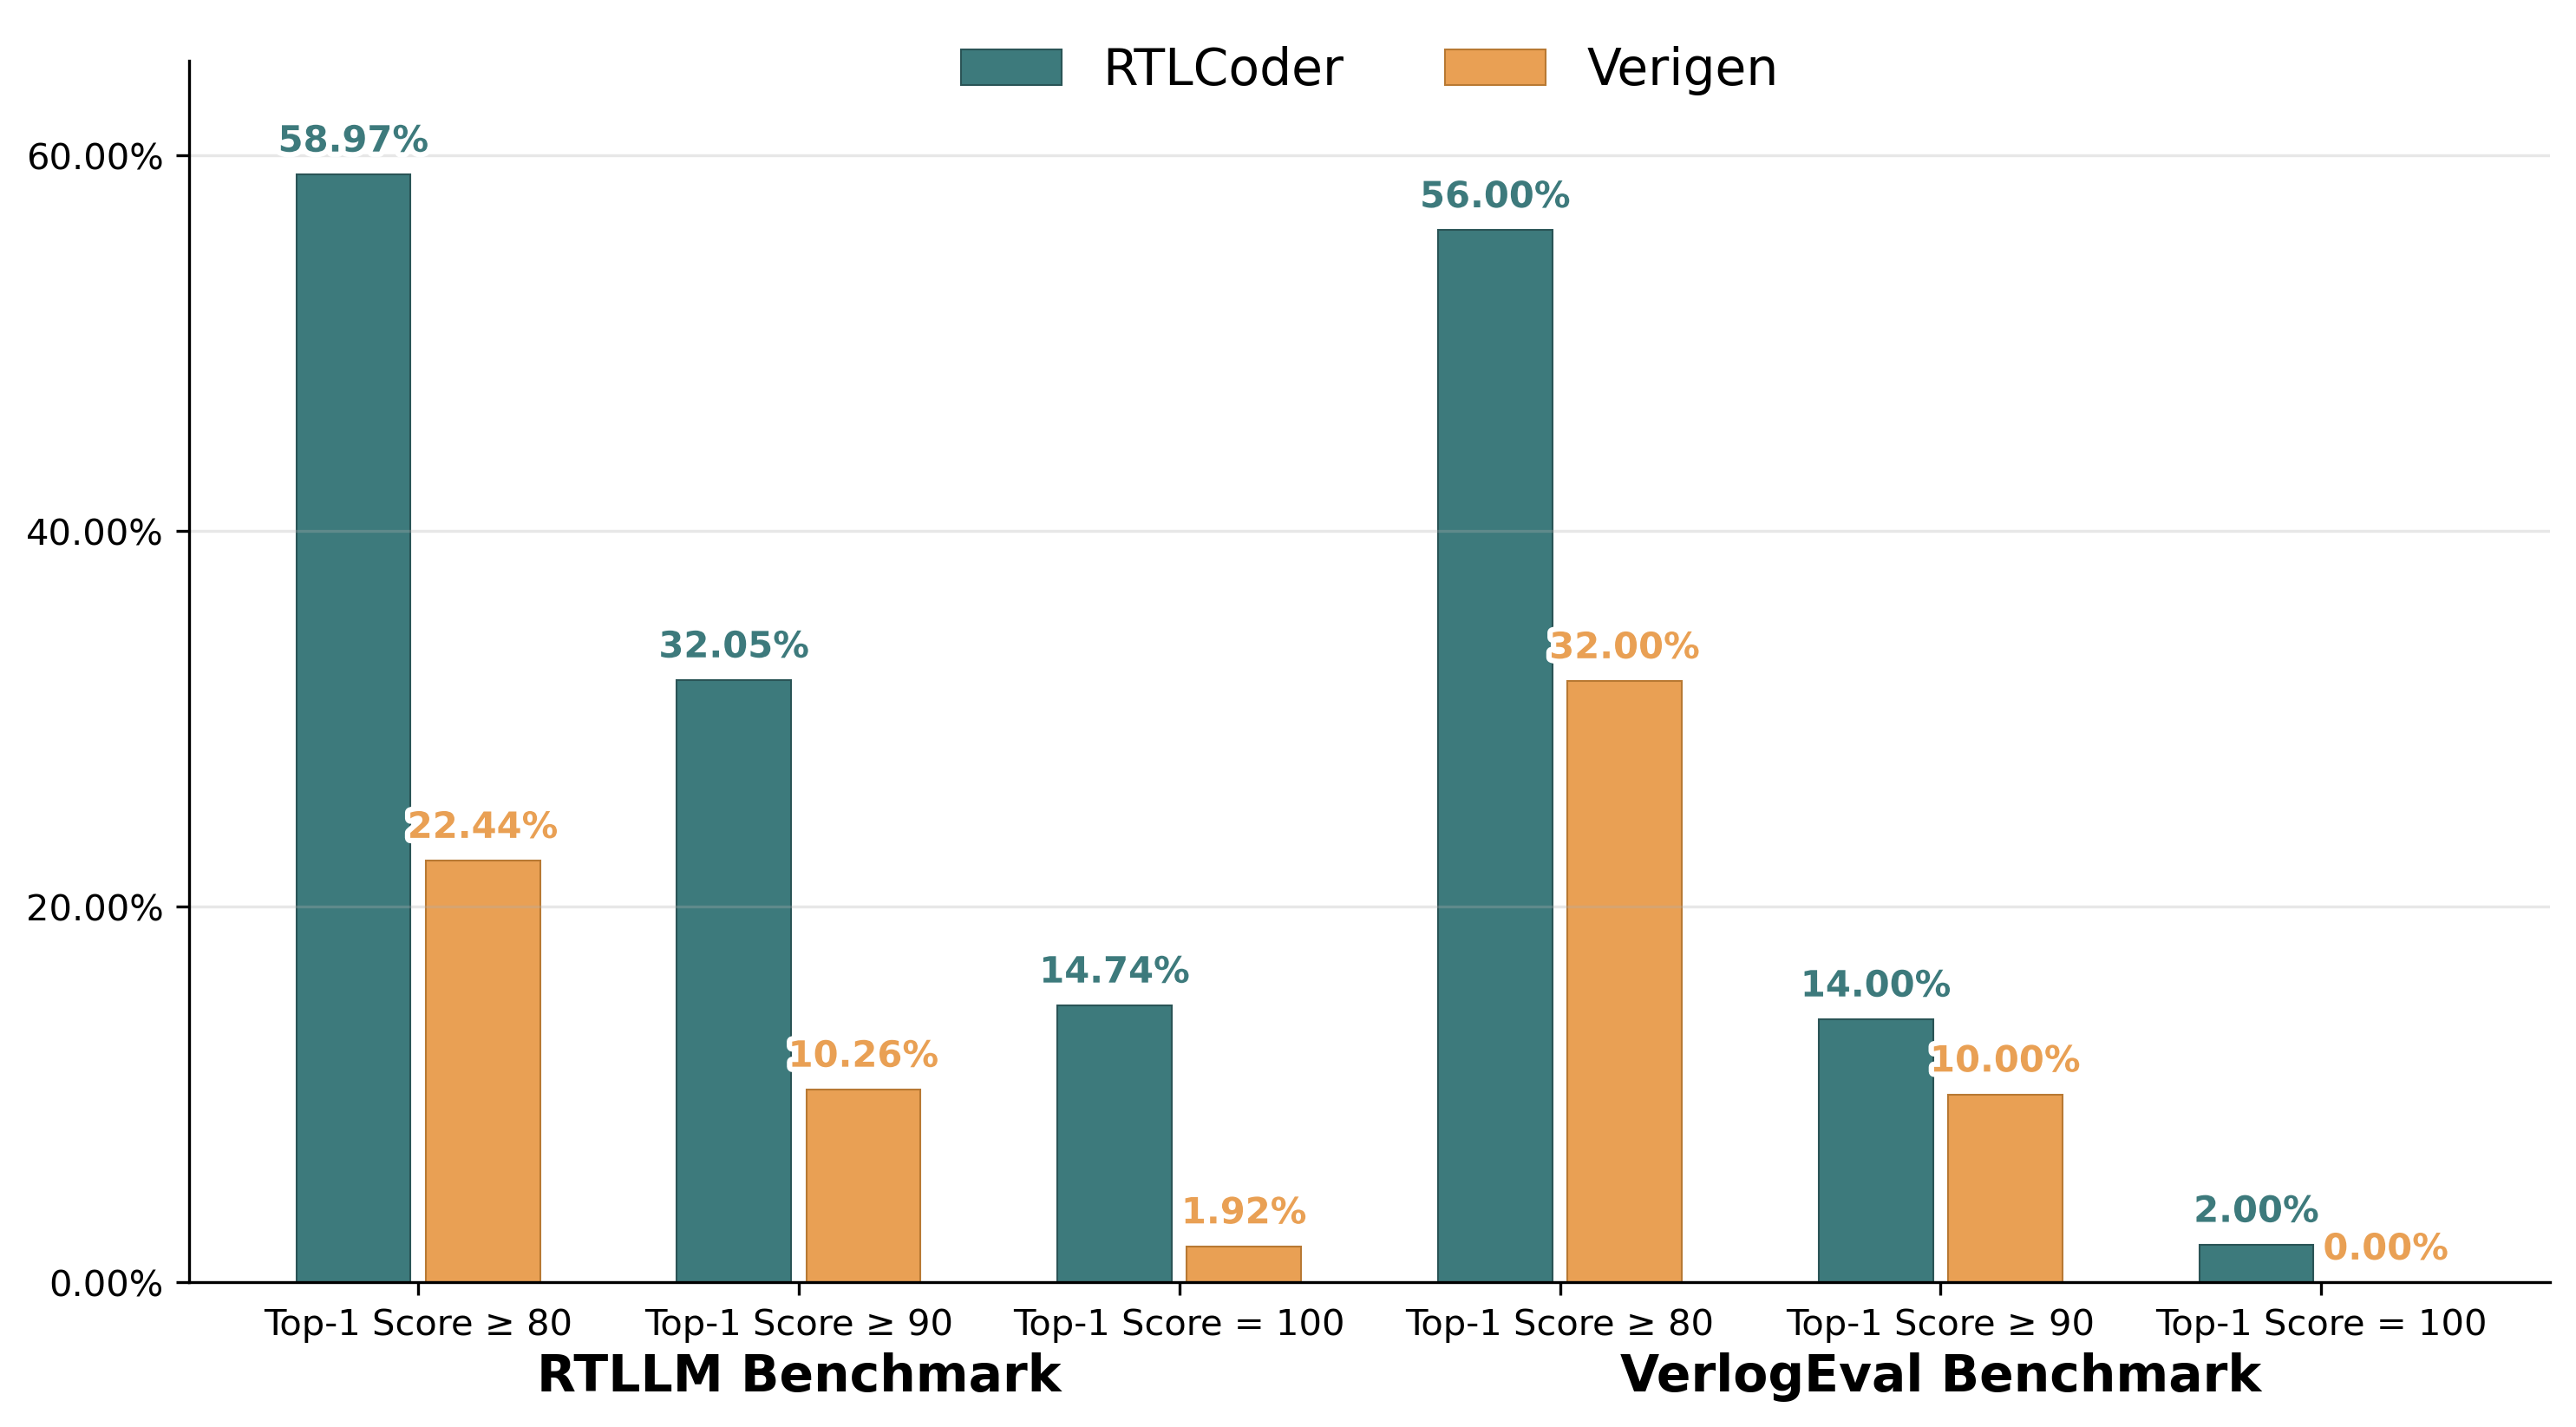

# Preparation for Inferences and Contamination Evaluations

In [ ]:
# install the required packages
!pip install -q -U pip wheel
!pip uninstall -y -q unsloth unsloth-zoo transformers trl datasets tokenizers accelerate bitsandbytes xformers protobuf tyro cut-cross-entropy || true
!pip install -q --no-cache-dir "protobuf==5.29.1"

!pip install -q -U unsloth unsloth-zoo
!pip install -q -U sentencepiece hf_transfer

import importlib, torch
print("torch:", torch.__version__, "| cuda:", torch.cuda.is_available())

mods = ["unsloth","unsloth_zoo","transformers","trl","datasets","tokenizers","accelerate","bitsandbytes","xformers"]
for m in mods:
    try:
        mod = importlib.import_module(m)
        print(f"{m:16s}", getattr(mod, "__version__", "(no __version__)"))
    except Exception as e:
        print(f"{m:16s} -> ERROR:", e)

try:
    from google.protobuf import __version__ as pb_version
    from google.protobuf import message, descriptor
    print("google.protobuf:", pb_version, "| OK:", message is not None and descriptor is not None)
except Exception as e:
    print("google.protobuf -> ERROR:", e)

!nvidia-smi || true



Here we call Llama3.1-8B for the VerilogEval and RTLLM inferences

In [ ]:
import json, zlib, math, gc
import numpy as np
from pathlib import Path

import torch
import torch.nn.functional as F
from transformers import AutoTokenizer, AutoModelForCausalLM


Interative login in Huggingface

In [ ]:
# Interactive login (will open an input box for you to paste your Hugging Face token)
!pip install -q -U huggingface_hub
from huggingface_hub import login
login()  # Paste your token (format: hf_xxx) and press Enter



Here we download the VerilogEval and RTLLM benchmarks.

In [ ]:
!pip install -q gdown
!gdown --id 1R1PCMjG0WI6UyrY2xYdb7MlQgH8bHaPi --output RTLLM.json
!gdown --id 1nOLaaARulITTTJTAVunnMDZej4q0I9R7 --output VerilogEval.json

/usr/local/lib/python3.12/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1R1PCMjG0WI6UyrY2xYdb7MlQgH8bHaPi
To: /content/RTLLM.json
100% 224k/224k [00:00<00:00, 94.2MB/s]
/usr/local/lib/python3.12/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1nOLaaARulITTTJTAVunnMDZej4q0I9R7
To: /content/VerilogEval.json
100% 783k/783k [00:00<00:00, 55.5MB/s]


This function is used to load *Llama-3.1-8B*

In [ ]:
def load_llama31_8b():
    model_name = "meta-llama/Llama-3.1-8B-Instruct"
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    if tokenizer.pad_token_id is None:
        tokenizer.pad_token = tokenizer.eos_token

    model = AutoModelForCausalLM.from_pretrained(
        model_name,
        device_map="auto",
        torch_dtype=torch.float16,  #fp16 for T4
    )
    model.eval()
    return model, tokenizer

model, tokenizer = load_llama31_8b()
device = next(model.parameters()).device
print("Loaded:", device, "| pad_token_id:", tokenizer.pad_token_id, "| eos_token_id:", tokenizer.eos_token_id)


This function computes:
- **PPL** = exp(-mean(log p))
- **ppl/zlib** = log(PPL) normalized by zlib compression length
- **Min-k% Prob** = negative mean of the lowest-k% token log-probs  

In [ ]:
def metrics_from_logprobs(text: str, all_logprobs: list[float]):
    """Return PPL, Min-k%, and related metrics."""
    # ppl = exp(-mean(log p))
    if len(all_logprobs) == 0:
        ppl = float("inf")
        mean_logp = float("-inf")
    else:
        mean_logp = float(np.mean(all_logprobs))
        ppl = float(np.exp(-mean_logp))

    # zlib compression length
    zlen = len(zlib.compress(text.encode("utf-8")))
    ppl_over_zlib = float(np.log(ppl) / zlen) if zlen > 0 and np.isfinite(ppl) else None

    # Min-k% (take the bottom k% of log p — lowest values = hardest tokens,
    # and compute their mean; multiply by -1 to match the original definition)
    mink = {}
    if len(all_logprobs) > 0:
        arr = np.sort(np.array(all_logprobs))  # ascending: smallest (hardest tokens) first
        for r in [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6]:
            k = max(1, int(len(arr) * r))
            mink[f"Min_{int(r*100)}% Prob"] = float(-np.mean(arr[:k]))
    return {"ppl": ppl, "mean_logp": mean_logp, "ppl/zlib": ppl_over_zlib, **mink}


def lower_ratio(p: float, p_lower: float):
    """Compute ppl/lowercase_ppl ratio (same definition as your original)."""
    try:
        return float(-(np.log(p_lower) / np.log(p)))
    except Exception:
        return None



Runs one greedy **inference** using the choosen model. It generates Verilog and calculates basic token-level metrics.

**What it does:**

*   Generates a greedy Verilog response for the given prompt

*   Computes token-level log-probs

*   Calculates metrics:

*   PPL (exp(-mean(log p)))

*   ppl/lowercase_ppl

*   ppl/zlib

*   Min-k% Prob (average of lowest-k% log-probs)


**Returns:**

A dictionary with:

*   mink_prob → probability metrics

*   cdd_pred → generated text

*   token_with_logprobs → per-token log-probs (if return_probs=True)

In [ ]:
SYSTEM_MSG = (
    "You only complete chats with syntax correct Verilog code. "
    "End the Verilog module code completion with 'endmodule'. "
    "Do not include module, input and output definitions and explanations in your response."
)
def run_one_llama31(prompt, model, tokenizer, max_new_tokens=256, return_probs=True):
    """
    Single inference:
      - Return greedy text
      - Compute token-level log probabilities (only if return_probs=True)
      - Compute ppl / ppl_lower / ppl_zlib / Min-k% Prob
        (same definition as your original script: -mean of worst k% logprobs)
      - When no reference model is available, set general_result_ref to None
    """
    import numpy as np, torch, zlib, gc

    def _gen_and_logprobs(msg_text):
        """Given a user text, return (generated_text, gen_logprobs[list of float], token_with_logprobs[list or None])."""
        messages = [
            {"role": "system", "content": SYSTEM_MSG},
            {"role": "user", "content": msg_text},
        ]
        # Encode + create attention_mask
        inputs = tokenizer.apply_chat_template(
            messages, add_generation_prompt=True, return_tensors="pt"
        )
        if tokenizer.pad_token_id is None:
            tokenizer.pad_token_id = tokenizer.eos_token_id
        # Left padding for stability
        tokenizer.padding_side = "left"
        # Explicitly build attention_mask
        attn = torch.ones_like(inputs)

        inputs = inputs.to(model.device)
        attn   = attn.to(model.device)

        with torch.no_grad():
            out = model.generate(
                inputs,
                attention_mask=attn,
                max_new_tokens=max_new_tokens,
                do_sample=True,
                output_scores=True,
                return_dict_in_generate=True,
                pad_token_id=tokenizer.eos_token_id,
            )

        seqs   = out.sequences
        scores = out.scores              # list[step] of (batch, vocab) logits
        prompt_len = inputs.shape[1]
        gen_ids = seqs[0, prompt_len:]   # Only take the newly generated part
        text = tokenizer.decode(gen_ids, skip_special_tokens=True)

        # Per-token probabilities / log probabilities
        logprobs = []
        tk_with_lp = [] if return_probs else None
        steps = min(len(gen_ids), len(scores))
        for i in range(steps):
            logits = scores[i][0]
            probs  = torch.softmax(logits, dim=-1)
            tok_id = gen_ids[i]
            p = probs[tok_id].item()
            if p <= 0.0:
                lp = -100.0
            else:
                lp = float(np.log(p))
            logprobs.append(lp)
            if return_probs:
                tk_with_lp.append([tokenizer.decode([tok_id]), lp])

        return text, logprobs, tk_with_lp

    # 1) Regular prompt inference
    greedy_text, logprobs, token_with_logprobs = _gen_and_logprobs(prompt)

    # 2) Lowercased prompt (for p1_lower / ratio; no token-level outputs needed)
    lower_text, lower_logprobs, _ = _gen_and_logprobs(prompt.lower())

    # === ppl ===
    ppl = None
    if logprobs:
        ppl = float(np.exp(-np.mean(logprobs)))
    p1_lower = None
    if lower_logprobs:
        p1_lower = float(np.exp(-np.mean(lower_logprobs)))

    # === ppl/lowercase_ppl ===
    ppl_lower_ratio = None
    if ppl and p1_lower:
        ppl_lower_ratio = float(-(np.log(p1_lower) / np.log(ppl)))

    # === ppl/zlib ===
    ppl_zlib = None
    if ppl:
        zbits = len(zlib.compress(prompt.encode("utf-8")))
        ppl_zlib = float(np.log(ppl) / zbits) if zbits > 0 else None

    # === Min-k% Prob ===
    min_k = {}
    if logprobs:
        arr = np.asarray(logprobs, dtype=np.float64)
        arr_sorted = np.sort(arr)
        n = len(arr_sorted)
        for k in [5, 10, 20, 30, 40, 50, 60]:
            m = max(1, int(n * (k / 100.0)))
            worst = arr_sorted[:m]
            min_k[f"Min_{k:.1f}% Prob"] = float(-np.mean(worst))

    gc.collect()
    torch.cuda.empty_cache()

    return {
        "pred": {
            "general_result": {"p1": ppl, "p1_lower": p1_lower},
        },
        "mink_prob": {
            "general_result": {"p1": ppl, "p1_lower": p1_lower},
            "general_result_ref": {"p_ref": None, "p_ref_lower": None},
            "ppl": ppl,
            "ppl/Ref_ppl (calibrate PPL to the reference model)": None,
            "ppl/lowercase_ppl": ppl_lower_ratio,
            "ppl/zlib": ppl_zlib,
            **min_k,
        },
        "cdd_pred": {
            "greedy_sample": greedy_text,
            "samples": [],
        },
        "token_with_logprobs": token_with_logprobs if return_probs else None,
    }


Runs **batch inference** using the model for multiple prompts.
Generates samples for later evaluations and saves all results.

**What it does:**

*   Iterates through all prompts in data_list

*   Generates one greedy sample and required CDD samples

*   Computes token-level metrics (PPL, Min-k%, etc.)

*   Saves all outputs and metrics into a JSON file

**Returns:**
A saved JSON file containing all prompts, generated results, and probability metrics.

In [ ]:
def run_batch_llama31(
    data_list,
    model, tokenizer,
    max_new_tokens=256,
    cdd_num=3,
    out_dir="./outputs",
    out_name="response_meta-llama_Llama-3.1-8B-Instruct.json",
    key_name="input",
):
    from pathlib import Path
    import json, torch, gc

    Path(out_dir).mkdir(parents=True, exist_ok=True)
    all_payload = []

    for i, ex in enumerate(data_list):
        prompt = ex[key_name]

        # First greedy inference: keep both token_with_logprobs and mink_prob
        res = run_one_llama31(prompt, model, tokenizer, max_new_tokens=max_new_tokens, return_probs=True)
        greedy_tokens = res["token_with_logprobs"]
        greedy_sample = res["cdd_pred"]["greedy_sample"]

        # Subsequent CDD runs: only keep the sample text
        cdd_samples = []
        for _ in range(cdd_num):
            res_cdd = run_one_llama31(prompt, model, tokenizer, max_new_tokens=max_new_tokens, return_probs=False)
            cdd_samples.append(res_cdd["cdd_pred"]["greedy_sample"])

        item = {
            "model_name": "meta-llama/Llama-3.1-8B-Instruct",
            "input_id": f"VerilogEval_Prob{str(i).zfill(4)}",
            "case": ex.get("case", f"case{str(i).zfill(4)}"),
            "prompt": prompt,
            "prompt_lower": prompt.lower(),
            "message": greedy_sample,
            "message_lower": None,
            "token_with_logprobs": greedy_tokens,   # Only available for greedy inference
            "token_with_logprobs_lower": None,
            "general_result": res["pred"]["general_result"],
            "mink_prob": res["mink_prob"],         # Keep the complete mink_prob structure
            "cdd": {
                "greedy_sample": greedy_sample,
                "samples": cdd_samples,
                "standard_solution": ex.get("ref", None),
            },
        }
        all_payload.append(item)

        torch.cuda.empty_cache()
        gc.collect()

    out_path = str(Path(out_dir) / out_name)
    with open(out_path, "w") as f:
        f.write(json.dumps(all_payload, indent=2, ensure_ascii=False))
    print("Saved ->", out_path)
    return all_payload


Since the available inference sources are limited, we do not present the complete inference process for all benchmarks. Moreover, computing the original Min-K% metric requires a high-quality model as reference, which is also computationally expensive. Therefore, we have commented out this function and instead generate token probabilities directly, which remains effective for our case. Additionally, we provide the full log files later so that you can reproduce our evaluation results using our released evaluation tool.

Due to the constraints of computational resources and running time of google colab, here we only run 2 examples in this experiment. You can try larger example numbers either on devices with more computational resources or spending more time here

In [ ]:
def extract_toy_data(jsonl_path, n=2):
    toy_data = []
    with open(jsonl_path, 'r') as f:
        for i, line in enumerate(f):
            if i >= n:
                break
            data = json.loads(line)
            prompt = data.get("prompt") or data.get("input")
            ref = data.get("ref")
            toy_data.append({
                "case": f"task{i:04d}",
                "input": prompt,
                "ref": ref
            })
    return toy_data

# take the first two prompt questions from VerilogEval benchmark

toy_data = extract_toy_data("/content/VerilogEval.json", n=2)
print(toy_data)


[{'case': 'task0000', 'input': '\nBuild a circuit that always outputs a LOW.\n\nmodule TopModule (\n  output zero\n);\n\n', 'ref': "\nmodule RefModule (\n  output zero\n);\n\n  assign zero = 1'b0;\n\nendmodule\n\n"}, {'case': 'task0001', 'input': '\nBuild a circuit with no inputs and one output. That output should always\ndrive 0 (or logic low).\n\nmodule TopModule (\n  output out\n);\n\n', 'ref': "\nmodule RefModule (\n  output out\n);\n\n  assign out = 1'b0;\n\nendmodule\n\n"}]


In [ ]:
# Here we generate only 2 samples for CDD evaluation for toy example
max_tokens = 256

_ = run_batch_llama31(
    toy_data,
    model, tokenizer,
    max_new_tokens=max_tokens,
    cdd_num=2,
    out_dir="./outputs",
    out_name="response_meta-llama_Llama-3.1-8B-Instruct.json",
    key_name="input",
)

Saved -> outputs/response_meta-llama_Llama-3.1-8B-Instruct.json


# CDD and Min-K% Evaluation

In case you do not have enough resources to lanuch all of inferences for the VerilogEval and RTLLM benchmark, here we also release the logging file for these two benchmarks using LLaMA-3.1-8B. In the log file, each test is evaluated once for the Min-K% Prob and 50 times for the CDD evaluation.

Here we show the algorithm designs for CDD and Min-K%

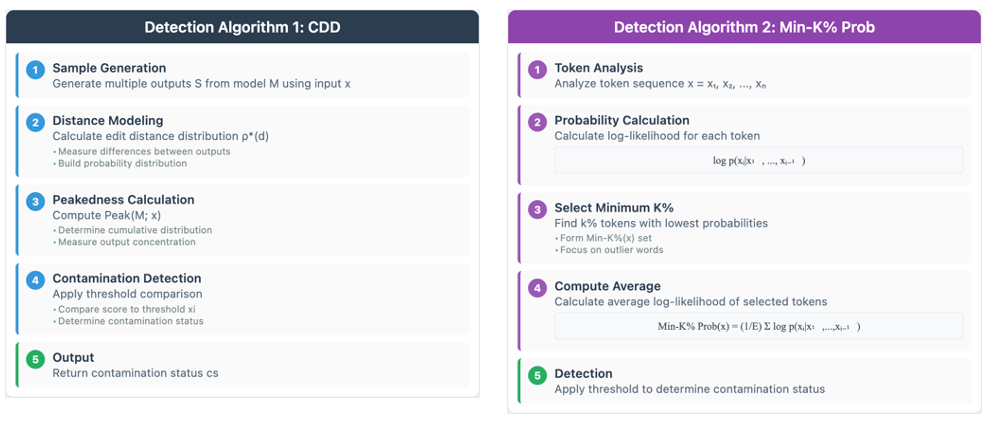

Load the logging files in case you do not want to infer all of test cases.

In [ ]:
!gdown --id 1X1Nm3YSYAylrqHIDld_wq5ctm0UGSLYp --output RTLLM_inference_log.json
!gdown --id 1oQ_QNR7I5rByhuygNcYhAgaWswBfoEg2 --output VerilogEval_inference_log.json

/usr/local/lib/python3.12/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1X1Nm3YSYAylrqHIDld_wq5ctm0UGSLYp
To: /content/RTLLM_inference_log.json
100% 5.89M/5.89M [00:00<00:00, 43.4MB/s]
/usr/local/lib/python3.12/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1oQ_QNR7I5rByhuygNcYhAgaWswBfoEg2
To: /content/VerilogEval_inference_log.json
100% 12.0M/12.0M [00:00<00:00, 73.5MB/s]


**CDD evaluation**

load the CDD evaluation code into the current location.

In [ ]:
!gdown --id 1bRodshCvJ516T579_r0PEq1fZRM2oIMQ --output CDD_eval.py

/usr/local/lib/python3.12/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1bRodshCvJ516T579_r0PEq1fZRM2oIMQ
From (redirected): https://drive.google.com/uc?id=1bRodshCvJ516T579_r0PEq1fZRM2oIMQ&confirm=t&uuid=3a0d053e-87d7-4191-b44e-ebed4071d6e0
To: /content/CDD_eval.py
100% 15.9k/15.9k [00:00<00:00, 44.1MB/s]


run the CDD evaluation using different alpha values

In [ ]:
import subprocess, shlex
alphas = [round(i * 0.05, 2) for i in range(21)]

for alpha in alphas:
    cmd = f'python CDD_eval.py --alpha {alpha} --model meta-llama/Llama-3.1-8B-Instruct ' \
          f'--input_path /content/VerilogEval_inference_log.json --output_file /content/VerilogEval_cdd.csv'
    print(">>", cmd)
    # Capture stdout and stderr
    result = subprocess.run(shlex.split(cmd), capture_output=True, text=True)
    print(result.stdout)
    print(result.stderr)
    result.check_returncode() # This will raise CalledProcessError if the script failed

>> python CDD_eval.py --alpha 0.0 --model meta-llama/Llama-3.1-8B-Instruct --input_path /content/VerilogEval_inference_log.json --output_file /content/VerilogEval_cdd.csv
Processed tasks: 156
peak result (boolean): [True, True, True, True, True, True, False, True, False, False, True, True, True, True, False, False, True, False, False, True, False, False, False, True, False, True, True, True, False, False, True, True, False, True, False, False, False, True, True, False, False, False, True, False, False, False, False, True, False, False, True, False, False, False, True, True, False, True, True, False, False, False, False, True, False, False, False, False, True, False, False, False, False, False, False, False, False, False, True, False, True, False, False, False, True, False, True, False, False, False, False, True, False, False, False, False, True, False, True, True, False, False, False, False, False, False, False, False, False, True, False, False, False, False, False, False, False, False

In [ ]:
for alpha in alphas:
    cmd = f'python CDD_eval.py --alpha {alpha} --model meta-llama/Llama-3.1-8B-Instruct ' \
          f'--input_path /content/RTLLM_inference_log.json --output_file /content/RTLLM_cdd.csv'
    print(">>", cmd)
    # Capture stdout and stderr
    result = subprocess.run(shlex.split(cmd), capture_output=True, text=True)
    print(result.stdout)
    print(result.stderr)
    result.check_returncode() # This will raise CalledProcessError if the script failed

>> python CDD_eval.py --alpha 0.0 --model meta-llama/Llama-3.1-8B-Instruct --input_path /content/RTLLM_inference_log.json --output_file /content/RTLLM_cdd.csv
Processed tasks: 50
peak result (boolean): [False, False, False, True, False, False, True, True, False, False, False, False, False, False, False, True, True, False, False, False, False, False, False, False, False, False, False, False, True, True, False, False, True, False, False, False, False, False, False, True, False, False, False, False, False, False, False, False, True, False]
Accuracy = 0.200000
Precision = 1.000000
Recall = 0.200000
F1Score = 0.333333
AUC = nan

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(

>> python CDD_eval.py --alpha 0.05 --model meta-llama/Llama-3.1-8B-Instruct --input_path /content/RTLLM_inference_log.json --output_file /content/RTLLM_cdd.csv
Processed tas

CDD result plot


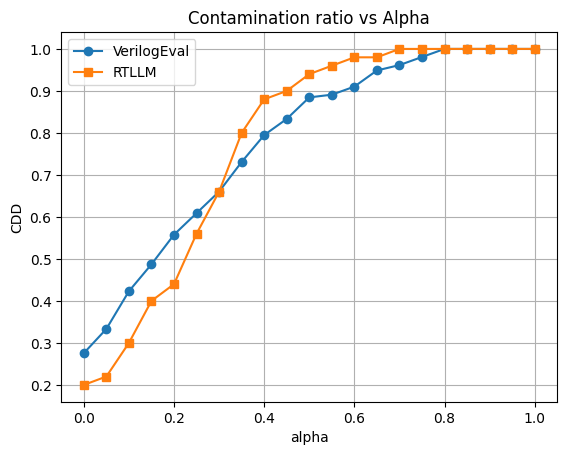

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

verilog_df = pd.read_csv("/content/VerilogEval_cdd.csv")
rtllm_df = pd.read_csv("/content/RTLLM_cdd.csv")

plt.plot(verilog_df["alpha"], verilog_df["accuracy"], marker='o', label="VerilogEval")
plt.plot(rtllm_df["alpha"], rtllm_df["accuracy"], marker='s', label="RTLLM")

plt.xlabel("alpha")
plt.ylabel("CDD")
plt.title("Contamination ratio vs Alpha")
plt.legend()
plt.grid(True)
plt.show()

**Min-K% evaluation**

load the Min-K% evaluation code into the local location

In [ ]:
!gdown --id 1Gf-ydf_yFJgt19jU9VHlLrhrSfFFJDSn --output mink_eval.py

/usr/local/lib/python3.12/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1Gf-ydf_yFJgt19jU9VHlLrhrSfFFJDSn
From (redirected): https://drive.google.com/uc?id=1Gf-ydf_yFJgt19jU9VHlLrhrSfFFJDSn&confirm=t&uuid=0bdd2565-21ab-4560-bce3-d6e21569e992
To: /content/mink_eval.py
100% 8.12k/8.12k [00:00<00:00, 25.2MB/s]


run the mink evaluation

In [ ]:
!python mink_eval.py \
  --input_path /content/VerilogEval_inference_log.json \
  --model meta-llama/Llama-3.1-8B-Instruct \
  --out_jsonl /content/VerilogEval_mink.jsonl

!python mink_eval.py \
  --input_path /content/RTLLM_inference_log.json \
  --model meta-llama/Llama-3.1-8B-Instruct \
  --out_jsonl /content/RTLLM_mink.jsonl

meta-llama/Llama-3.1-8B-Instruct
Processed model: meta-llama/Llama-3.1-8B-Instruct
Wrote to: /content/VerilogEval_mink.jsonl
meta-llama/Llama-3.1-8B-Instruct
Processed model: meta-llama/Llama-3.1-8B-Instruct
Wrote to: /content/RTLLM_mink.jsonl


In [ ]:
import json
import matplotlib.pyplot as plt
import numpy as np

def read_series_by_model(jsonl_path, target_model):
    """Find the entry for the target model in a JSONL file and return its min_20_prob_acc_list."""
    with open(jsonl_path, "r") as f:
        for line in f:
            if not line.strip():
                continue
            rec = json.loads(line)
            if rec.get("model") == target_model:
                return rec.get("min_20_prob_acc_list", [])
    return []



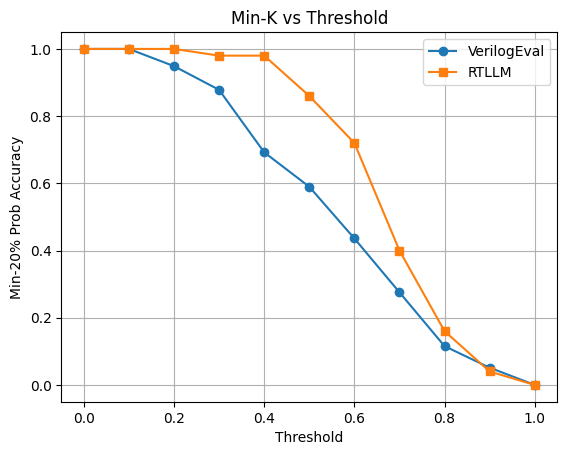

In [ ]:
verilog_file = "/content/VerilogEval_mink.jsonl"
rtllm_file   = "/content/RTLLM_mink.jsonl"

target_model = "meta-llama/Llama-3.1-8B-Instruct"

verilog_series = read_series_by_model(verilog_file, target_model)
rtllm_series   = read_series_by_model(rtllm_file, target_model)

x = np.linspace(0, 1, len(verilog_series))

plt.figure()
if verilog_series:
    plt.plot(x, verilog_series, marker='o', label="VerilogEval")
if rtllm_series:
    plt.plot(x, rtllm_series, marker='s', label="RTLLM")
plt.xlabel("Threshold")
plt.ylabel("Min-20% Prob Accuracy")
plt.title(f"Min-K vs Threshold")
plt.grid(True)
plt.legend()
plt.show()

# TED Mitigation Evaluation

**TED Mitigation Evaluation**

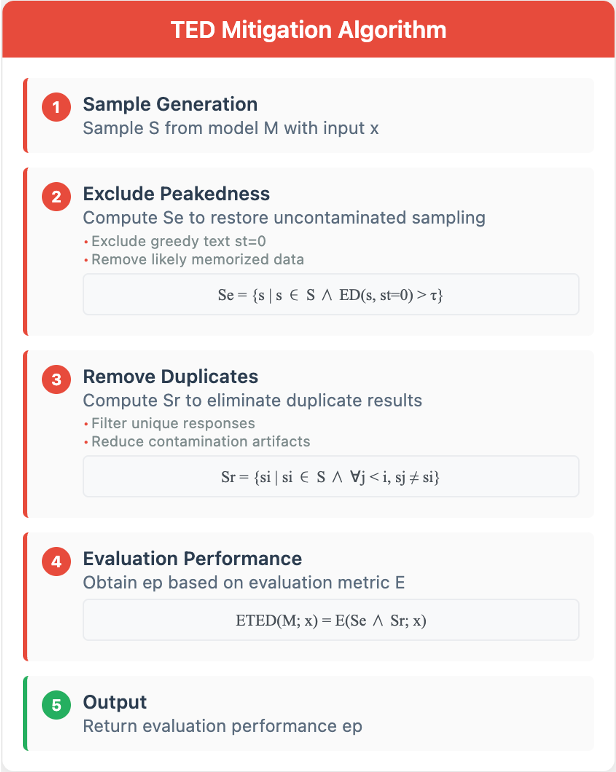

In the paper implementation, we used the fine-tuned LLaMA3.1-8B using RTL-Coder or VeriGen. Therefore, to assess the mitigation effectivenss easily, here we also release the log file which you could use it easily.

Load the log files here.

In [ ]:
!gdown --id 1vy6xFaES6I_3js6L65_ngMjuh3ZRDoIi --output TED_eval.py

/usr/local/lib/python3.12/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1vy6xFaES6I_3js6L65_ngMjuh3ZRDoIi
From (redirected): https://drive.google.com/uc?id=1vy6xFaES6I_3js6L65_ngMjuh3ZRDoIi&confirm=t&uuid=d9416462-3009-456f-ba0c-933a4068f97b
To: /content/TED_eval.py
100% 7.25k/7.25k [00:00<00:00, 22.9MB/s]


In [ ]:
!gdown --id 17xLXEVhIFX0GnoAk_dG-z2FJAyMtdPhu --output RTLLM_RTLCoder.json
!gdown --id 11ks5-NEtIlOfriO-2DBQhmefqSa6x1Hr --output RTLLM_VeriGen.json

!gdown --id 1Un2vONAcQXSSsJ0blo4Yv1cadnBEQ8Ri --output VerilogEval_RTLCoder.json
!gdown --id 1w75jaoL_8QOct5nFxNWDJiBtj6txElTp --output VerilogEval_VeriGen.json

/usr/local/lib/python3.12/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=17xLXEVhIFX0GnoAk_dG-z2FJAyMtdPhu
To: /content/RTLLM_RTLCoder.json
100% 15.2M/15.2M [00:00<00:00, 61.9MB/s]
/usr/local/lib/python3.12/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=11ks5-NEtIlOfriO-2DBQhmefqSa6x1Hr
To: /content/RTLLM_VeriGen.json
100% 13.0M/13.0M [00:00<00:00, 52.4MB/s]
/usr/local/lib/python3.12/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
Fro

run the TED mitigation using different tau values

In [ ]:
import subprocess, shlex

model = "meta-llama/Llama-3.1-8B-Instruct"
input_path = "/content/VerilogEval_VeriGen.json"
output_path = "/content/TED_VerilogEval_VeriGen.jsonl"

for tau in range(5, 101, 5):
    cmd = f"python TED_eval.py --tau {tau} --model {model} --input_path {input_path} --out_jsonl {output_path}"
    print(">>", cmd)
    # Capture stdout and stderr
    result = subprocess.run(shlex.split(cmd), capture_output=True, text=True)
    print(result.stdout)
    print(result.stderr)
    result.check_returncode() # This will raise CalledProcessError if the script failed

>> python TED_eval.py --tau 5 --model meta-llama/Llama-3.1-8B-Instruct --input_path /content/VerilogEval_VeriGen.json --out_jsonl /content/TED_VerilogEval_VeriGen.jsonl
[INFO] Saved tau=5.0 results to /content/TED_VerilogEval_VeriGen.jsonl


>> python TED_eval.py --tau 10 --model meta-llama/Llama-3.1-8B-Instruct --input_path /content/VerilogEval_VeriGen.json --out_jsonl /content/TED_VerilogEval_VeriGen.jsonl
[INFO] Saved tau=10.0 results to /content/TED_VerilogEval_VeriGen.jsonl


>> python TED_eval.py --tau 15 --model meta-llama/Llama-3.1-8B-Instruct --input_path /content/VerilogEval_VeriGen.json --out_jsonl /content/TED_VerilogEval_VeriGen.jsonl
[INFO] Saved tau=15.0 results to /content/TED_VerilogEval_VeriGen.jsonl


>> python TED_eval.py --tau 20 --model meta-llama/Llama-3.1-8B-Instruct --input_path /content/VerilogEval_VeriGen.json --out_jsonl /content/TED_VerilogEval_VeriGen.jsonl
[INFO] Saved tau=20.0 results to /content/TED_VerilogEval_VeriGen.jsonl


>> python TED_eval.py --ta

In [ ]:
model = "meta-llama/Llama-3.1-8B-Instruct"
input_path = "/content/VerilogEval_RTLCoder.json"
output_path = "/content/TED_VerilogEval_RTLCoder.jsonl"

for tau in range(5, 101, 5):
    cmd = f"python TED_eval.py --tau {tau} --model {model} --input_path {input_path} --out_jsonl {output_path}"
    print(">>", cmd)
    # Capture stdout and stderr
    result = subprocess.run(shlex.split(cmd), capture_output=True, text=True)
    print(result.stdout)
    print(result.stderr)
    result.check_returncode() # This will raise CalledProcessError if the script failed

>> python TED_eval.py --tau 5 --model meta-llama/Llama-3.1-8B-Instruct --input_path /content/VerilogEval_RTLCoder.json --out_jsonl /content/TED_VerilogEval_RTLCoder.jsonl
[INFO] Saved tau=5.0 results to /content/TED_VerilogEval_RTLCoder.jsonl


>> python TED_eval.py --tau 10 --model meta-llama/Llama-3.1-8B-Instruct --input_path /content/VerilogEval_RTLCoder.json --out_jsonl /content/TED_VerilogEval_RTLCoder.jsonl
[INFO] Saved tau=10.0 results to /content/TED_VerilogEval_RTLCoder.jsonl


>> python TED_eval.py --tau 15 --model meta-llama/Llama-3.1-8B-Instruct --input_path /content/VerilogEval_RTLCoder.json --out_jsonl /content/TED_VerilogEval_RTLCoder.jsonl
[INFO] Saved tau=15.0 results to /content/TED_VerilogEval_RTLCoder.jsonl


>> python TED_eval.py --tau 20 --model meta-llama/Llama-3.1-8B-Instruct --input_path /content/VerilogEval_RTLCoder.json --out_jsonl /content/TED_VerilogEval_RTLCoder.jsonl
[INFO] Saved tau=20.0 results to /content/TED_VerilogEval_RTLCoder.jsonl


>> python TED_

In [ ]:
model = "meta-llama/Llama-3.1-8B-Instruct"
input_path = "/content/RTLLM_VeriGen.json"
output_path = "/content/TED_RTLLM_VeriGen.jsonl"

for tau in range(5, 101, 5):
    cmd = f"python TED_eval.py --tau {tau} --model {model} --input_path {input_path} --out_jsonl {output_path}"
    print(">>", cmd)
    # Capture stdout and stderr
    result = subprocess.run(shlex.split(cmd), capture_output=True, text=True)
    print(result.stdout)
    print(result.stderr)
    result.check_returncode() # This will raise CalledProcessError if the script failed

>> python TED_eval.py --tau 5 --model meta-llama/Llama-3.1-8B-Instruct --input_path /content/RTLLM_VeriGen.json --out_jsonl /content/TED_RTLLM_VeriGen.jsonl
[INFO] Saved tau=5.0 results to /content/TED_RTLLM_VeriGen.jsonl


>> python TED_eval.py --tau 10 --model meta-llama/Llama-3.1-8B-Instruct --input_path /content/RTLLM_VeriGen.json --out_jsonl /content/TED_RTLLM_VeriGen.jsonl
[INFO] Saved tau=10.0 results to /content/TED_RTLLM_VeriGen.jsonl


>> python TED_eval.py --tau 15 --model meta-llama/Llama-3.1-8B-Instruct --input_path /content/RTLLM_VeriGen.json --out_jsonl /content/TED_RTLLM_VeriGen.jsonl
[INFO] Saved tau=15.0 results to /content/TED_RTLLM_VeriGen.jsonl


>> python TED_eval.py --tau 20 --model meta-llama/Llama-3.1-8B-Instruct --input_path /content/RTLLM_VeriGen.json --out_jsonl /content/TED_RTLLM_VeriGen.jsonl
[INFO] Saved tau=20.0 results to /content/TED_RTLLM_VeriGen.jsonl


>> python TED_eval.py --tau 25 --model meta-llama/Llama-3.1-8B-Instruct --input_path /content/RTLL

In [ ]:
model = "meta-llama/Llama-3.1-8B-Instruct"
input_path = "/content/RTLLM_RTLCoder.json"
output_path = "/content/TED_RTLLM_RTLCoder.jsonl"

for tau in range(5, 101, 5):
    cmd = f"python TED_eval.py --tau {tau} --model {model} --input_path {input_path} --out_jsonl {output_path}"
    print(">>", cmd)
    # Capture stdout and stderr
    result = subprocess.run(shlex.split(cmd), capture_output=True, text=True)
    print(result.stdout)
    print(result.stderr)
    result.check_returncode() # This will raise CalledProcessError if the script failed

>> python TED_eval.py --tau 5 --model meta-llama/Llama-3.1-8B-Instruct --input_path /content/RTLLM_RTLCoder.json --out_jsonl /content/TED_RTLLM_RTLCoder.jsonl
[INFO] Saved tau=5.0 results to /content/TED_RTLLM_RTLCoder.jsonl


>> python TED_eval.py --tau 10 --model meta-llama/Llama-3.1-8B-Instruct --input_path /content/RTLLM_RTLCoder.json --out_jsonl /content/TED_RTLLM_RTLCoder.jsonl
[INFO] Saved tau=10.0 results to /content/TED_RTLLM_RTLCoder.jsonl


>> python TED_eval.py --tau 15 --model meta-llama/Llama-3.1-8B-Instruct --input_path /content/RTLLM_RTLCoder.json --out_jsonl /content/TED_RTLLM_RTLCoder.jsonl
[INFO] Saved tau=15.0 results to /content/TED_RTLLM_RTLCoder.jsonl


>> python TED_eval.py --tau 20 --model meta-llama/Llama-3.1-8B-Instruct --input_path /content/RTLLM_RTLCoder.json --out_jsonl /content/TED_RTLLM_RTLCoder.jsonl
[INFO] Saved tau=20.0 results to /content/TED_RTLLM_RTLCoder.jsonl


>> python TED_eval.py --tau 25 --model meta-llama/Llama-3.1-8B-Instruct --input_path /

Based on the saved result, compute mitigation impact for different pass@k

In [ ]:
import json, csv

def ted_all_removed_metrics(input_jsonl, output_csv):
    """
    Read a JSONL file generated by TED_eval.py, compute pass@1, pass@5, pass@10, and pass@15
    (based on the 'all_removed' definition), and save the results to a CSV file.

    Args:
        input_jsonl (str): Path to the JSONL file output from TED_eval.py.
        output_csv (str): Path to the CSV file where the computed metrics will be saved.
    """
    Ks = [1, 5, 10, 15]

    def all_removed_metrics(removed_solutions, Ks):
        """
        Compute pass@K (all_removed) metrics.

        For each task, if the top-K indices (0..K-1) are all present
        in the 'removed_solutions' list, it counts as a pass.

        Args:
            removed_solutions (dict): Mapping of case name → list of removed indices.
            Ks (list[int]): List of K values to evaluate (e.g., [1, 5, 10, 15]).

        Returns:
            dict: { "pass@1_all_removed": float, ..., "pass@15_all_removed": float }
        """
        items = list(removed_solutions.items())
        n = len(items)
        if n == 0:
            return {f"pass@{k}_all_removed": 0.0 for k in Ks}

        out = {}
        for k in Ks:
            topk = set(range(k))
            all_cnt = 0
            for _, removed_list in items:
                if topk.issubset(set(removed_list)):
                    all_cnt += 1
            out[f"pass@{k}_all_removed"] = all_cnt / n
        return out

    rows = []
    with open(input_jsonl, "r") as f:
        run_idx = 0
        for line in f:
            line = line.strip()
            if not line:
                continue
            rec = json.loads(line)
            removed = rec.get("removed_solutions", {})
            metrics = all_removed_metrics(removed, Ks)

            # Add an initial zero row for better plotting alignment
            if run_idx == 0:
                init_row = {"run": -1, "tau": 0}
                for k in Ks:
                    init_row[f"pass@{k}_all_removed"] = 0.0
                rows.append(init_row)

            row = {
                "run": run_idx,
                "tau": rec.get("tau", None),
                **metrics
            }
            rows.append(row)
            run_idx += 1

    fieldnames = ["run", "tau"] + [f"pass@{k}_all_removed" for k in Ks]
    with open(output_csv, "w", newline="") as fd:
        w = csv.DictWriter(fd, fieldnames=fieldnames)
        w.writeheader()
        w.writerows(rows)

    print(f"✅ Done. Wrote {len(rows)} runs to {output_csv}")


Save the ted mitigation effects into the output files.

In [ ]:
ted_all_removed_metrics(
    input_jsonl="/content/TED_VerilogEval_VeriGen.jsonl",
    output_csv="/content/TED_acc_VerilogEval_VeriGen.csv"
)
ted_all_removed_metrics(
    input_jsonl="/content/TED_VerilogEval_RTLCoder.jsonl",
    output_csv="/content/TED_acc_VerilogEval_RTLCoder.csv"
)
ted_all_removed_metrics(
    input_jsonl="/content/TED_RTLLM_VeriGen.jsonl",
    output_csv="/content/TED_acc_RTLLM_VeriGen.csv"
)
ted_all_removed_metrics(
    input_jsonl="/content/TED_RTLLM_RTLCoder.jsonl",
    output_csv="/content/TED_acc_RTLLM_RTLCoder.csv"
)

✅ Done. Wrote 21 runs to /content/TED_acc_VerilogEval_VeriGen.csv
✅ Done. Wrote 21 runs to /content/TED_acc_VerilogEval_RTLCoder.csv
✅ Done. Wrote 21 runs to /content/TED_acc_RTLLM_VeriGen.csv
✅ Done. Wrote 21 runs to /content/TED_acc_RTLLM_RTLCoder.csv


plot the TED effects.

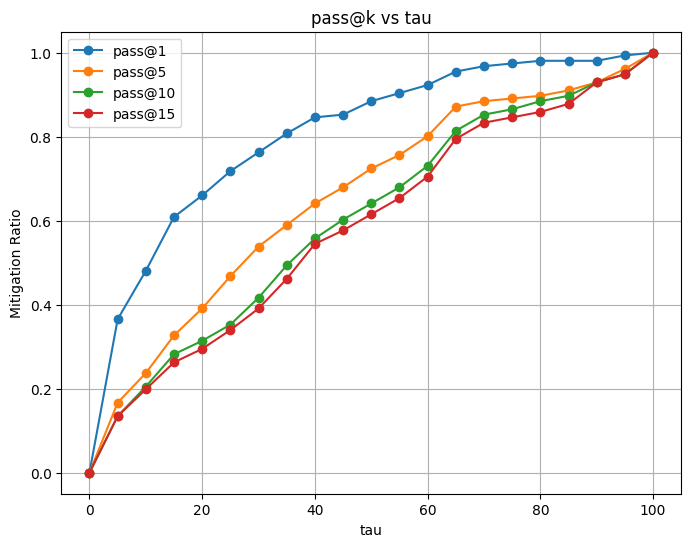

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_pass_all(csv_path):
    df = pd.read_csv(csv_path)
    df = df.dropna(subset=['tau'])
    df = df.sort_values('tau')

    ks = [1, 5, 10, 15]
    plt.figure(figsize=(8, 6))
    for k in ks:
        col = f"pass@{k}_all_removed"
        if col in df.columns:
            plt.plot(df['tau'], df[col], marker='o', label=f"pass@{k}")

    plt.xlabel("tau")
    plt.ylabel("Mitigation Ratio")
    plt.title("pass@k vs tau")
    plt.legend()
    plt.grid(True)
    plt.show()

plot_pass_all("/content/TED_acc_VerilogEval_VeriGen.csv")

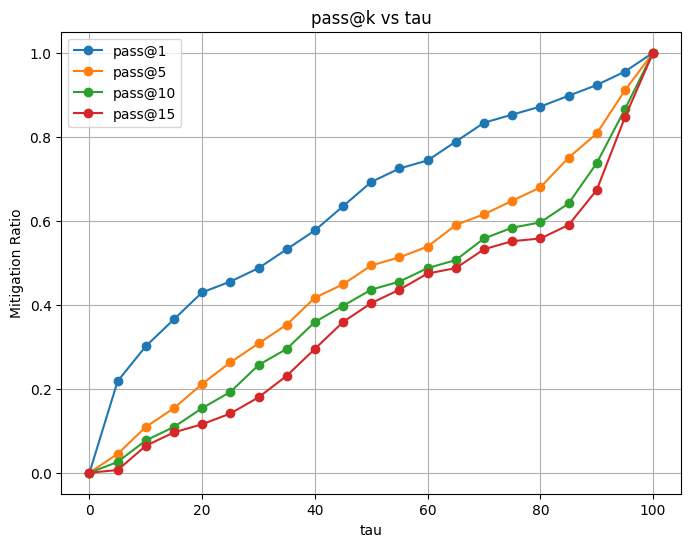

In [ ]:
plot_pass_all("/content/TED_acc_VerilogEval_RTLCoder.csv")

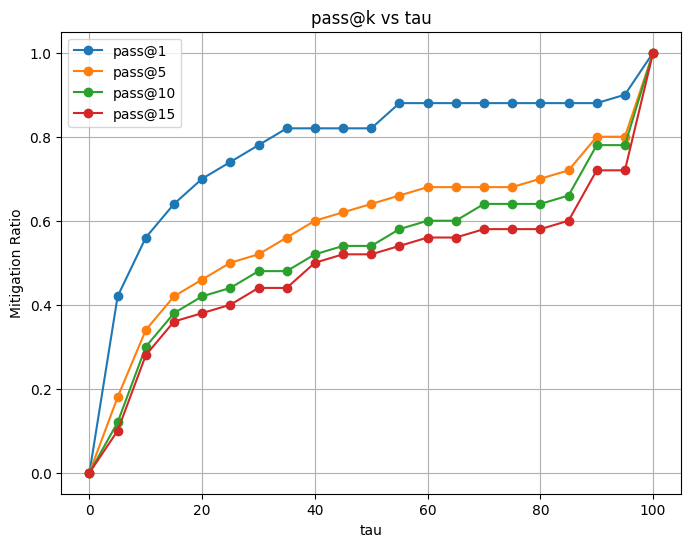

In [ ]:
plot_pass_all("/content/TED_acc_RTLLM_VeriGen.csv")

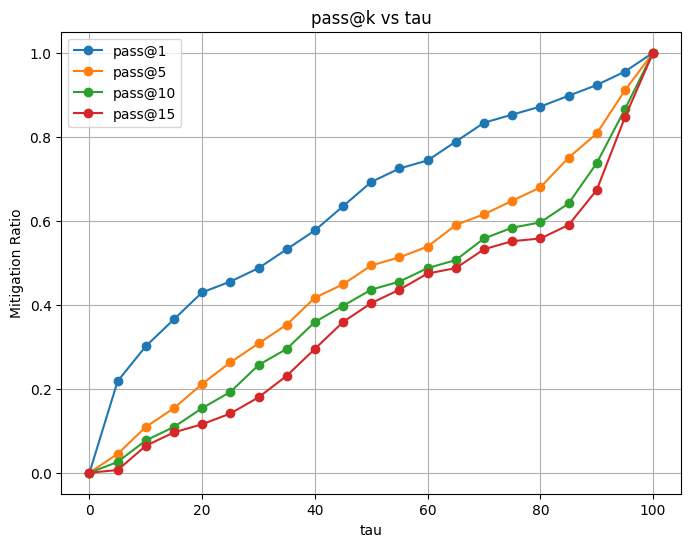

In [ ]:
plot_pass_all("/content/TED_acc_RTLLM_RTLCoder.csv")